In [3]:
import numpy as np
from pathlib import Path
import spatialdata_io
import spatialdata
import json
import time
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from joblib import Parallel, delayed

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
from QC import QC
import coexpression
import readwrite
cfg = readwrite.config()

def sample_files(dir_segmentation_cohort, samples=None):
    files = {}
    for sample_path in pathlib.Path(dir_segmentation_cohort).iterdir():
        for replicate_path in sample_path.iterdir():
            sample_name = replicate_path.stem

            if samples is not None and sample_name not in samples:
                continue
            elif 'corrupted' in sample_name:
                continue
            else:
                if segmentation != 'default':
                    files[sample_name] = replicate_path / "normalised_results/outs"
                else:
                    files[sample_name] = replicate_path

    return files


def gen_tasks(ads,replicates,ref_segmentation):
    ''' Generate tasks for parallel processing '''
    tasks_ref = []
    tasks_seg = []
    for replicate in replicates:
        ads_sample = ads.loc[:, :, :, :, replicate]

        assert len(np.unique(ads_sample.index.get_level_values('sample'))) == 1
        sample = ads_sample.index.get_level_values('sample')[0]
        sample_cohorts = np.unique(ads_sample.index.get_level_values('cohort'))
        sample_panels = np.unique(ads_sample.index.get_level_values('panel'))
        sample_segmentations = np.unique(ads_sample.index.get_level_values('segmentation'))

        for cohort in sample_cohorts:
            for panel in sample_panels:
                for segmentation in sample_segmentations:
                    if segmentation == ref_segmentation:
                        tasks_ref.append((segmentation,cohort,panel,sample,replicate))
                    else:
                        tasks_seg.append((segmentation,cohort,panel,sample,replicate))
    return tasks_ref, tasks_seg


def process_sample(ads, segmentation, cohort, panel, sample, replicate, target_count, method, cc_cutoff, min_positivity_rate, log2, pos_rate_ref_seg=None, CCref=None):
    k = (segmentation,cohort,panel,sample,replicate)
    ad_seg = ads.loc[k]
    sc.pp.filter_cells(ad_seg, min_genes=1)

    CCseg, Xseg_downsampled, pos_seg, pos_rate_seg, mask_seg = coexpression.coexpression(ad_seg,
        target_count=target_count,method=method)

    if CCref is not None:
        CCdiff, spurious_gene_pairs = coexpression.compare_segmentations(
            CCref, CCseg, 
            pos_rate_ref_seg=pos_rate_ref_seg, pos_rate_other_seg=pos_rate_seg, min_positivity_rate=min_positivity_rate, 
            cc_cutoff = cc_cutoff,
            method=method, log2=log2)

        return k, CCseg, pos_rate_seg, CCdiff, spurious_gene_pairs
    else:
        return k, CCseg, pos_rate_seg

def process_ref_samples(ads, tasks_ref,n_jobs=-1):
    ''' Collect results for ref seg '''
    results_ref = Parallel(n_jobs=n_jobs)(delayed(process_sample)(
        ads, segmentation,cohort,panel,sample,replicate, target_count, method, cc_cutoff, min_positivity_rate, log2
    ) for segmentation,cohort,panel,sample,replicate in tasks_ref)

    CCref = {}
    pos_rate_ref = {}
    for result in results_ref:
        if result is not None:
            k, CCref_k, pos_rate_ref_k = result
            CCref[k] = CCref_k
            pos_rate_ref[k] = pos_rate_ref_k

    return CCref, pos_rate_ref

def process_seg_samples(ads, tasks_seg,CCref, pos_rate_ref,n_jobs=-1):
    ''' Collect results for other segs compared to ref seg '''
    results_seg = Parallel(n_jobs=-1)(delayed(process_sample)(
        ads, segmentation,cohort,panel,sample,replicate, target_count, method, cc_cutoff, min_positivity_rate,log2,
        pos_rate_ref[ref_segmentation,cohort,panel,sample,replicate], CCref[ref_segmentation,cohort,panel,sample,replicate]
    ) for segmentation,cohort,panel,sample,replicate in tasks_seg)


    CCseg = {}
    pos_rate_seg = {}
    CCdiff = {}
    spurious_gene_pairs = {}
    for result in results_seg:
        if result is not None:
            k, CCseg_k, pos_rate_seg_k, CCdiff_k, spurious_gene_pairs_k = result
            CCseg[k] = CCseg
            pos_rate_seg[k] = pos_rate_seg_k
            CCdiff[k] = CCdiff_k
            spurious_gene_pairs[k] = spurious_gene_pairs_k

    return CCseg, pos_rate_seg, CCdiff, spurious_gene_pairs


def read_cc_file(k, method, target_count, results_dir):
    """
    Worker function to read Parquet files for a specific method and target count.
    """
    out_file_coexpr = results_dir / f'coexpression/{"/".join(k)}/coexpression_{method}_{target_count}.parquet'
    out_file_pos_rate = results_dir / f'coexpression/{"/".join(k)}/positivity_rate_{method}_{target_count}.parquet'
    
    cc = pd.read_parquet(out_file_coexpr)
    pos_rate = pd.read_parquet(out_file_pos_rate)[0]
    return method, target_count, cc, pos_rate


def read_cc_files(cc_paths, results_dir):

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(read_cc_file, k, method, target_count, results_dir)
            for k, method, target_count in cc_paths
        ]

        CC = {}
        pos_rate = {}
        for future in concurrent.futures.as_completed(futures):
            method, target_count, cc, pr = future.result()
            k = cc_paths[futures.index(future)][0]  # Retrieve the `k` corresponding to this future
            
            if k not in CC:
                CC[k] = {}
            if k not in pos_rate:
                pos_rate[k] = {}

            CC[k][method, target_count] = cc
            pos_rate[k][method, target_count] = pr
    return CC, pos_rate

## Load data

In [5]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}
# dir_segmentations['default'] = xenium_raw_data_dir

# Params
SEGMENTATIONS = list(dir_segmentations.keys())
COHORTS = [p.stem for p in xenium_raw_data_dir.iterdir() if p.is_dir()]
COHORTS_PANELS = {cohort: [p.stem for p in (xenium_raw_data_dir / cohort).iterdir()] for cohort in COHORTS}
COHORTS_SAMPLES = {(cohort,panel): 
                        [replicate.stem 
                        for sample in (xenium_raw_data_dir / cohort / panel).iterdir()
                        for replicate in sample.iterdir()
                        if 'corrupt' not in replicate.name and 'output' not in replicate.name and replicate.is_dir()] 
                    for cohort in COHORTS 
                    for panel in COHORTS_PANELS[cohort]}


# Read resegmentations and RCTD
# Coexpression params
methods = ['conditional','jaccard','pearson','spearman']
target_counts = [30,50]

xenium_paths = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for cohort in (cohorts := segmentation.iterdir()): 
        for panel in (panels := cohort.iterdir()):
            for sample in (samples := panel.iterdir()):
                for replicate in (replicates := sample.iterdir()):
                    
                    k = (segmentation.stem,cohort.stem,panel.stem,sample.stem,replicate.stem)
                    replicate_path = replicate / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = replicate_path

                    if replicate_path.exists():

                        for method in methods:
                            for target_count in target_counts:
                                cc_paths.append((k, method, target_count))
                                # out_file_coexpr = results_dir / f'coexpression/{name}/coexpression_{method}_{target_count}.parquet' 
                                # out_file_pos_rate = results_dir / f'coexpression/{name}/positivity_rate_{method}_{target_count}.parquet'
                    
                                # CC[k][method,target_count] = pd.read_parquet(out_file_coexpr)
                                # pos_rate[k][method,target_count] = pd.read_parquet(out_file_pos_rate)[0]


CC, pos_rate = read_cc_files(cc_paths, results_dir)
# ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,sample_name_as_key=False)
# ads = pd.Series(ads.values(),
#                 index=pd.Index(ads.keys(),name = ('segmentation','cohort','panel','sample','replicate')),
#                 dtype=object).sort_index()

('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'NSCLC', 'lung', '0WMU', '0WMU')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '0WMU', '0WMU')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'breast', 'breast', '0OE1', '0OE1')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '0WMU', '0WMU')
('segger', 'NSCLC', 'lung', '0WMU', '0WMU')
('segger', 'NSCLC', 'lung', '1G73', '1G73_2')
('segger', 'NSCLC', 'lung', '0WMU', '0WMU')
('segger', 'NSCLC', 'lung', '0WMU', 

## General QC

In [3]:
# for name,f in all_files.items():
#     if pathlib.Path(cfg['figures_dir']+f'xenium/QC/{name}.png').exists():
#         print('skipping',name,f)
#         continue
#     else:
#         # try:
#         # sd = readwrite.read_xenium_samples({name:f},anndata_only=False,transcripts=True)[name]
#         QC(sd,name,cfg['figures_dir']+f'xenium/QC/{name}.png')
#         %xdel sd
#         # except:
#         #     print('failed',name,f)

In [4]:
# failed_samples = ['1G4Y', '1G11']
# for name,f in all_files.items():
#     if name.split('-')[2] in failed_samples:
#         print(name)
#         sd = readwrite.read_xenium({name:f},anndata_only=False,transcripts=True)[name]

## Coexpression

### Find spurious genes as in proseg paper

In [5]:
# # Constants
# target_count = 50
# method = 'jaccard'
# min_positivity_rate = 0.01
# cc_cutoff = 1.5
# log2 = False
# ref_segmentation = '10x_0um'
# ref_oversegmentation = '10x_15um'
# replicates = ads.index.get_level_values('replicate').unique()
# # samples = ['1GA2',]

# tasks_ref, tasks_seg = gen_tasks(ads,replicates,ref_segmentation)
# CCref, pos_rate_ref =  process_ref_samples(ads,tasks_ref,n_jobs=1)
# CCseg, pos_rate_seg, CCdiff, spurious_gene_pairs = process_seg_samples(ads,tasks_seg, CCref, pos_rate_ref,n_jobs=-1)

340428 / 854443 ( 39.84 % ) cells reaching the target count
124209 / 672007 ( 18.48 % ) cells reaching the target count
692606 / 856880 ( 80.83 % ) cells reaching the target count
684264 / 856842 ( 79.86 % ) cells reaching the target count
716639 / 1168408 ( 61.33 % ) cells reaching the target count
569318 / 812876 ( 70.04 % ) cells reaching the target count
342084 / 685186 ( 49.93 % ) cells reaching the target count
327930 / 684962 ( 47.88 % ) cells reaching the target count
337254 / 712053 ( 47.36 % ) cells reaching the target count
297623 / 636119 ( 46.79 % ) cells reaching the target count


In [7]:
# Coexpression params
min_positivity_rate = 0.01
cc_cutoff = 1.5
log2 = False
ref_segmentation = '10x_0um'

CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}
    for m in methods:
        for t in target_counts:
            k_ref = (ref_segmentation,*k[1:])

            (CCdiff[k][m,t], 
            spurious_gene_pairs[k][m,t]) = coexpression.compare_segmentations(
                                CC_ref_seg = CC[k_ref][m,t], 
                                CC_other_seg = CC[k][m,t], 
                                pos_rate_ref_seg=pos_rate[k_ref][m,t], 
                                pos_rate_other_seg=pos_rate[k][m,t], 
                                min_positivity_rate=min_positivity_rate, 
                                cc_cutoff = cc_cutoff,
                                method=m, log2=log2)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-p

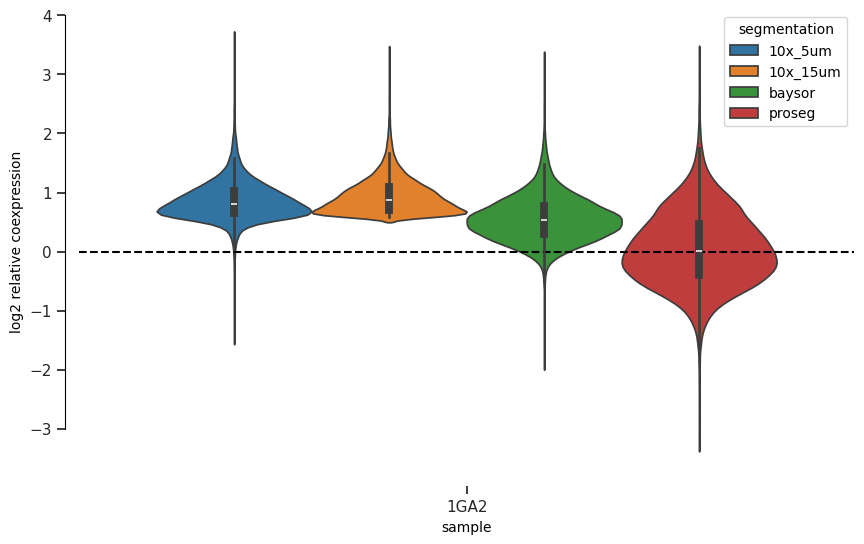

In [12]:
method = 'jaccard'
target_count = 50
ref_oversegmentation = '10x_15um'
cohort = 'NSCLC'
panel = 'chuvio'
sample = '1GA2'
replicate = sample
log2 = True

data = []
for k in CCdiff.keys():
    k_ref_over = (ref_oversegmentation,*k[1:])

    mat = CCdiff[k][method,target_count].replace(1.,np.nan)
    if log2:
        mat = np.log2(mat)
        
    i = spurious_gene_pairs[k_ref_over][method,target_count][:,0]
    j = spurious_gene_pairs[k_ref_over][method,target_count][:,1]
    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)] 
    data.extend(np.hstack((np.tile(k,(len(i),1)),flat_values[:,None])))

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data, columns=ads.index.names+['log2 relative coexpression'])
df['log2 relative coexpression']=df['log2 relative coexpression'].astype(float)

# Create joint boxplot
plt.figure(figsize=(10, 6))
plt.axhline(0,c='k',linestyle='--')
g=sns.violinplot(data=df, x="sample", y="log2 relative coexpression",hue='segmentation')#showfliers=1)
# plt.title("Joint Boxplot of Distance Matrices")
# plt.ylabel("Distance")
# plt.xlabel("Matrix")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.set_theme(style="ticks", palette=None)
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
target_count = 50
method = 'jaccard'
min_positivity_rate = 0.01
cc_cutoff = 1.5
ref_segmentation = '10x_0um'
ref_oversegmentation_ = '10x_15um'
samples = ['1GA2']

CCseg = {}
CCdiff = {}
spurious_gene_pairs = {}
for sample in samples:
    ads_sample = ads.loc[:,:,:,sample]
    sample_cohorts = np.unique(ads_sample.index.get_level_values('cohort'))
    sample_panels = np.unique(ads_sample.index.get_level_values('panel'))
    sample_segmentations = np.unique(ads_sample.index.get_level_values('segmentation'))

    for cohort in sample_cohorts:
        for panel in sample_panels:
            print(sample,cohort,panel)
            
            # compute CC for reference segmentations
            ad_ref = ads.loc[ref_segmentation,cohort,panel,sample]
            sc.pp.filter_cells(ad_ref, min_genes=1)

            CCref, Xref_downsampled, pos_ref, pos_rate_ref, mask_ref = coexpression.coexpression(ad_ref,
                target_count=target_count,method=method)

            # compute CC and CCdiff with all other segmentations
            for segmentation in sample_segmentations:
                if segmentation == ref_segmentation:
                    continue

                k = (segmentation,cohort,panel,sample)
                ad_seg = ads.loc[k]
                sc.pp.filter_cells(ad_seg, min_genes=1)

                CCseg[k], Xseg_downsampled, pos_seg, pos_rate_seg, mask_seg = coexpression.coexpression(ad_seg,
                target_count=target_count,method=method)

                CCdiff[k], spurious_gene_pairs[k] = coexpression.compare_segmentations(
                    CCref, CCseg[k], 
                    pos_rate_ref_seg=pos_rate_ref, pos_rate_other_seg=pos_rate_seg, 
                    min_positivity_rate=min_positivity_rate, cc_cutoff = cc_cutoff,
                    method=method)

# df_ct_markers_cc = coexpression.coexpression_by_cell_type(CCref,spurious_genes_markers,df_markers_panel)
# sns.heatmap(df_ct_markers_cc,cmap='Purples')
# plt.show()

1GA2 NSCLC chuvio
340428 / 854443 ( 39.84 % ) cells reaching the target count
692606 / 856880 ( 80.83 % ) cells reaching the target count


ValueError: Unable to coerce to Series, length must be 340: given 1

In [ ]:
marker_genes_idx = sd1.var_names.isin(u_markers_panel)
pos_nuc_markers = pos_nuc[:,marker_genes_idx]

CC_cells = coexpression.coexpression_cells(pos_nuc)
CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
plt.hist(CC_cells_sum,bins=50)
plt.show()

sd1.obs.loc[mask_nuc,'CC_cells_sum'] = CC_cells_sum

sc.set_figure_params(figsize=(15,15))
sc.pl.spatial(sd1[mask_nuc],spot_size=15,color='CC_cells_sum',cmap='viridis',vmax=50)
sc.pl.spatial(sd1[mask_nuc],spot_size=15,color='total_counts',cmap='viridis',vmax=150)

plt.scatter(sd1[mask_nuc].obs['total_counts'],sd1[mask_nuc].obs['CC_cells_sum'],alpha=.5)
np.corrcoef(sd1[mask_nuc].obs['total_counts'],sd1[mask_nuc].obs['CC_cells_sum'])[0,1]

## Find coexpressed and spurious genes scRNA

In [ ]:
ad = sc.read(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
ad_panel = ad[:,[g for g in sd1.var_names if g in ad.var_names]]

# compute CC
CCnuc_found = CCnuc.loc[ad_panel.var_names,ad_panel.var_names]
CCnuc_sc, Xnuc_downsampled_sc, pos_nuc_sc, pos_rate_nuc_sc, mask_nuc_sc = coexpression.coexpression(ad_panel,return_all=1)
CCdiff_sc, spurious_gene_pairs_sc = coexpression.compare_segmentations(pos_rate_nuc_sc, pos_rate_nuc, CCnuc_sc, CCnuc_found, min_positivity_rate=0.01,cc_cutoff = 2)
spurious_genes_idx_sc = np.unique(np.where(spurious_gene_pairs_sc))
spurious_genes_sc = ad_panel.var_names[spurious_genes_idx_sc]
spurious_genes_markers_sc = df_markers_panel.loc[df_markers_panel['canonical'].isin(spurious_genes_sc),'canonical'].unique()

print(len(spurious_genes_markers_sc), 'marker genes /', len(spurious_genes_sc),'spurious panel genes found')

# plot
sns.set(font_scale=.8)
# sns.clustermap(CCnuc.loc[spurious_genes,spurious_genes],yticklabels=True,xticklabels=True,figsize=(10,10))
sns.clustermap(CCdiff_sc.loc[spurious_genes_markers_sc,spurious_genes_markers_sc],
    yticklabels=True,xticklabels=True,figsize=(15,15),vmin=None,vmax=4,cmap='RdBu_r',center=1)
plt.show()

df_ct_markers_cc_nuc_sc, df_cc_melt_nuc_sc = coexpression.coexpression_by_cell_type(CCnuc_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='Purples')
plt.show()

df_ct_markers_cc_diff_sc, df_cc_melt_diff_sc = coexpression.coexpression_by_cell_type(CCdiff_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='RdBu_r',center=1)
plt.show()

In [ ]:
## 
df_markers_panel_ct = df_markers_panel.set_index("canonical")
df_cc_melt = df_cc_melt_nuc_sc.copy()
df_cc_melt['ct_genei'] = ''
df_cc_melt['ct_genej'] = ''
for i, row in df_cc_melt.iterrows():
    ct_genei = df_markers_panel_ct.loc[row["genei"], "index"]
    ct_genej = df_markers_panel_ct.loc[row["genej"], "index"]

    if isinstance(ct_genei, str):
        ct_genei = [ct_genei]
    if isinstance(ct_genej, str):
        ct_genej = [ct_genej]
    df_cc_melt.loc[df_cc_melt["genei"] == row["genei"],'ct_genei'] = ' & '.join(ct_genei) 
    df_cc_melt.loc[df_cc_melt["genej"] == row["genej"],'ct_genej'] = ' & '.join(ct_genej)

display(df_cc_melt[:20])

## Coexpression based on computational marker genes

### Estimate genes coexpression from scRNA

In [ ]:
# load doublets
# result = pyreadr.read_r('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/dbuszta/meso/processed_data/new_data/doublets_by_sample.rds')[None]

# load data
ad_sc = sc.read_h5ad(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
# ad_sc.obs['doublet_status'] = result.iloc[:,0]
# ad_sc = ad_sc[ad_sc.obs['doublet_status']=='singlet']
# ad_sc.obs = ad_sc.obs.join(pd.read_csv(cfg['results_dir']+'annotation/cell_type_annotation.csv',index_col=0))

# filter to xenium genes
xenium_panel_genes = pd.read_csv(cfg['data_dir']+'xenium_chuvio_panel_genes.csv',index_col=0)['0']
ad_sc_panel = ad_sc[:,ad_sc.var_names.isin(xenium_panel_genes)]

CT_KEY = 'cell_type_harmonized_level2_consensus'
u_cell_types = ad_sc_panel.obs[CT_KEY].unique()

# get df with max fraction for each cell type
(df_fraction,df_difference, 
df_max_difference) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 1., threshold_diff = 0.)
df_difference_sorted = df_difference[df_difference.max().sort_values().index]

# get df with thresholded max fraction for each cell type
(_,df_difference_thresholded, 
 df_max_difference_thresholded) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 0.01, threshold_diff = 0.25)
df_difference_thresholded_sorted = df_difference_thresholded[df_difference_thresholded.max().sort_values().index]

for df_difference_sorted_, df_max_difference_ in zip([df_difference_sorted,df_difference_thresholded_sorted],
                                                     [df_max_difference,df_max_difference_thresholded]):

    ### Boxplots
    plt.figure(figsize=(8,30))

    flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='black')
    ax = sns.boxplot(data=df_difference_sorted_, orient='h', flierprops=flierprops)

    # Loop over columns to find and highlight max fliers
    for i, col in enumerate(df_difference_sorted_.columns):
        data = df_difference_sorted_[col]
        max_val = data.max()  # Find maximum value in the column
        ax.scatter(max_val,i, color='red', edgecolor='black', zorder=5, s=20)

    plt.title("Difference in % of cells expressing")
    plt.show()

    ### Heatmap
    sns.heatmap(df_max_difference_)

# Define markers
df_markers_scores = pd.DataFrame(index=ad_sc_panel.var_names,columns=u_cell_types)

for cti in u_cell_types:
    cti_columns = df_difference_thresholded.columns.str.split("_").str[0] == cti

    df_markers_scores[cti] = df_difference_thresholded.loc[:,cti_columns].mean(1)

ct_markers = {}
for ct in u_cell_types:
    ct_scores = df_markers_scores[ct].sort_values(ascending=False).dropna()
    markers_ = list(ct_scores[(ct_scores>0.)][:10].index)

    if len(markers_) > 0:
        ct_markers[ct] = markers_

df_markers_computational = pd.DataFrame([
    {"index": k, "canonical": v}
    for k, values in ct_markers.items()
    for v in values
])

### Coexpression

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

normalized_entropy_computational = {}
CC_computational = {}
CC_cells_sum_normalized_computational = {}

for segmentation in SEGMENTATIONS:

    normalized_entropy_computational[segmentation] = {}
    CC_computational[segmentation] = {}
    CC_cells_sum_normalized_computational[segmentation] = {}
        
    for k,ad_ in ads[segmentation].items():
        print(k)

        ad = ad_[ad_.uns[rctd_weights_key].index]

        ### Entropy
        W = ad.uns[rctd_weights_key].copy()
        W[W<0] = 0.
        W = sklearn.preprocessing.normalize(W,axis=0,norm='l1')
        normalized_entropy_computational[segmentation][k] = scipy.stats.entropy(W,axis=1)/np.log(W.shape[1])

        ### Coexpression
        # compute CC
        CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad,target_count=30,method='jaccard')
        CC_computational[segmentation][k] = CC

        # load markers
        # df_markers_computational_panel = df_markers_computational[df_markers_computational['canonical'].isin(ad.var_names)]
        # u_markers_panel = df_markers_computational_panel['canonical'].unique()
        # marker_genes_idx = ad.var_names.isin(u_markers_panel)
        # print(len(u_markers_panel), 'marker genes /', ad.shape[1],'panel genes found')

        # df_ct_markers_cc = coexpression.coexpression_by_cell_type(CC,u_markers_panel,df_markers_computational_panel)
#         CC_cells = coexpression.coexpression_cells(pos)
#         CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
#         CC_cells_sum_normalized_computational[k] = np.array(CC_cells_sum)/(marker_genes_idx.sum()**2)
#         break

# palette = {'singlet':'green','doublet_certain':'blue','doublet_uncertain':'orange','reject':'red'}
# for segmentation in SEGMENTATIONS[:1]:
#     for k,ad_ in ads[segmentation].items():
#         ad = ad_[ad_.uns[rctd_weights_key].index]

#         g = sns.jointplot(x=normalized_entropy_computational[k], y=CC_cells_sum_normalized_computational[k], palette=palette,hue=ad.obs['spot_class_FLEX_original'],kind="scatter", height=5,s=8,alpha=.3)
#         g.set_axis_labels(f'{k} - normalized RCTD weights normalized entropy', f'{k} - normalized coexpression score')
#         plt.show()
#         break

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

# Define a function for processing one (segmentation, k) pair
def process_task(segmentation, k, ad_, rctd_weights_key):
    print(f"Processing {segmentation}, {k}")

    # Filter data
    ad = ad_[ad_.uns[rctd_weights_key].index]

    # Entropy computation
    W = ad.uns[rctd_weights_key].copy()
    W[W < 0] = 0.0
    W = sklearn.preprocessing.normalize(W, axis=0, norm='l1')
    normalized_entropy = scipy.stats.entropy(W, axis=1) / np.log(W.shape[1])

    # Coexpression computation
    CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad, target_count=30, method='jaccard')

    return segmentation, k, normalized_entropy, CC

# Prepare the tasks
tasks = []
for segmentation in SEGMENTATIONS:
    for k, ad_ in ads[segmentation].items():
        tasks.append((segmentation, k, ad_, rctd_weights_key))

# Run tasks in parallel
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_task)(segmentation, k, ad_, rctd_weights_key) for segmentation, k, ad_, rctd_weights_key in tasks
)

# Collect results
normalized_entropy_computational = {seg: {} for seg in SEGMENTATIONS}
CC_computational = {seg: {} for seg in SEGMENTATIONS}

for segmentation, k, entropy, CC in results:
    normalized_entropy_computational[segmentation][k] = entropy
    CC_computational[segmentation][k] = CC


In [ ]:
sample = '16MD_run14'
coexpr_scores = pd.DataFrame()
normalized_entropy_computational_scores = pd.DataFrame()
for segmentation,CC_segmentations in CC_computational.items():
    for sample, CC_sample in CC_segmentations.items():
        coexpr_scores.loc[segmentation,sample] = CC_sample.values[np.triu_indices_from(CC_sample,1)].sum()
        normalized_entropy_computational_scores.loc[segmentation,sample] = normalized_entropy_computational[segmentation][sample].sum()

sns.clustermap(coexpr_scores.fillna(coexpr_scores.mean()),figsize=(10,5),cmap='Reds')

coexpr_scores_norm = coexpr_scores.fillna(coexpr_scores.mean())
sns.clustermap(coexpr_scores_norm/coexpr_scores_norm.max(),figsize=(10,5),cmap='Reds')

sns.clustermap(normalized_entropy_computational_scores,figsize=(10,5),cmap='Reds')
sns.clustermap(normalized_entropy_computational_scores/normalized_entropy_computational_scores.max(),figsize=(10,5),cmap='Reds')

In [ ]:
median_transcripts_per_cell = pd.DataFrame()
for segmentation, ads_seg in ads.items():
    for sample, ad in ads_seg.items():
        median_transcripts_per_cell.loc[segmentation,sample] = ad.uns['metrics_summary'].loc[0,'median_transcripts_per_cell']

In [ ]:
df1 = normalized_entropy_computational_scores
df2 = coexpr_scores

plot_data = []
for idx in df1.index:
    for col in df1.columns:
        plot_data.append({
            'segmentation': idx,
            'samples': col,
            'normalized_entropy_computational_scores': df1.loc[idx, col],
            'coexpr_scores': df2.loc[idx, col]
        })

plot_df = pd.DataFrame(plot_data)

sns.boxplot(plot_df,x='segmentation',y='coexpr_scores');plt.show()
sns.boxplot(plot_df,x='segmentation',y='normalized_entropy_computational_scores')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='normalized_entropy_computational_scores',  # x-axis: values from df1
    y='coexpr_scores',  # y-axis: values from df2
    hue='segmentation',  # color based on segmentation
    style='samples',  # marker type based on samples
    s=50  # marker size
)

# plt.title('Scatter Plot: df1 vs df2')
# plt.xlabel('Values from df1')
# plt.ylabel('Values from df2')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# Find universal markers
ad_sc_panel.var['n_cells'] = (ad_sc_panel.X>0).sum(0).A1
ad_sc_panel.var['n_cells'].hist(bins=100)
CC, X_downsampled, pos_, pos_rate_, mask_ = coexpression.coexpression(ad_sc_panel,target_count=None,min_cond_coex=0.)

threshold = 0.01
pos_rate_threshold = 0.01

valid_genes = np.where(pos_rate > pos_rate_threshold)[0]

gene_pairs_idx = np.vstack((CC.values<threshold).nonzero()).T
gene_pairs_idx_u = pd.DataFrame(gene_pairs_idx)
gene_pairs_idx_u['Key'] = gene_pairs_idx_u.apply(lambda row: tuple(sorted(row)), axis=1)
gene_pairs_idx_u = gene_pairs_idx_u.drop_duplicates(subset='Key').drop(columns='Key')
gene_pairs_idx_u = gene_pairs_idx_u[gene_pairs_idx_u.isin(valid_genes).sum(1)==2]
gene_pairs_idx_u = gene_pairs_idx_u.values
print(len(gene_pairs_idx_u))

# Score xenium samples per gene
# CC_computational_scores = {}
# for segmentation in SEGMENTATIONS:
#     for k,ad_ in ads[segmentation].items():
#         CC_computational_scores[segmentation][k] = CC_computational[segmentation][k].values[gene_pairs_idx_u[:,0],gene_pairs_idx_u[:,1]].sum(1)

# Score xenium samples per cell
# CC_cells_score = coexpression.coexpression_cells_score_gene_pairs(CC_cells, gene_pairs_idx_u)

# ad.obs['CC_cells_score'] = CC_cells_score
# ad.obs['CC_cells_score'].hist(bins=100)

# sc.set_figure_params(figsize=(10,10))
# sc.pl.spatial(ad,color='CC_cells_score',spot_size=10,)
# (ad.obs['CC_cells_score']>0).sum()